In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
import eif as iso
import category_encoders as ce

# 1. Загрузка данных

In [2]:
%load_ext sql
%sql sqlite:///Diamonds

In [3]:
db = %sql select * from Diamond
db = db.DataFrame()
db = db.set_index("id")

 * sqlite:///Diamonds
Done.


# 2. Data preproccesing

In [4]:
db[:5]

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [5]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   x        40455 non-null  float64
 7   y        40455 non-null  float64
 8   z        40455 non-null  float64
 9   price    40455 non-null  float64
dtypes: float64(7), object(3)
memory usage: 3.4+ MB


In [6]:
db.describe()

,carat,depth,table,x,y,z,price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797576,61.746377,57.451694,5.729163,5.732896,3.537351,7.783822
std,0.475939,1.436796,2.234569,1.125244,1.154799,0.711002,1.016828
min,0.200000,43.000000,44.000000,0.000000,0.000000,0.000000,5.787000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,6.851000
50%,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,7.780000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,8.581000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,9.842000


In [7]:
db.describe(include=object)

,cut,color,clarity
count,40455,40455,40455
unique,5,7,8
top,Ideal,G,SI1
freq,16230,8410,9779


In [8]:
db.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [9]:
db.nunique()

carat       269
cut           5
color         7
clarity       8
depth       179
table       122
x           546
y           544
z           366
price      3512
dtype: int64

/tmp/ipykernel_9592/4111826463.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(db.corr(method='spearman'), annot=True, fmt=".2f")


<AxesSubplot: >

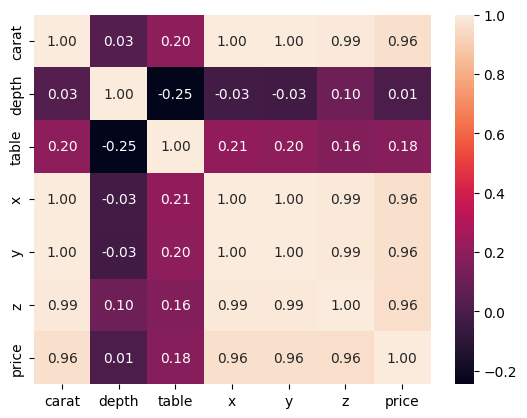

In [10]:
sns.heatmap(db.corr(method='spearman'), annot=True, fmt=".2f")

## 2.1 Target encoding + Normalization

In [11]:
encoder = ce.TargetEncoder(cols=['cut', 'color', 'clarity'])

/home/user/jupyter_env/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/user/jupyter_env/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [12]:
updated_columns = encoder.fit_transform(X=db.loc[:,'cut':'clarity'], y=db['depth'])

In [13]:
db2 = db
db2['cut'] = updated_columns['cut']
db2['color'] = updated_columns['color']
db2['clarity'] = updated_columns['clarity']
db2[:5]

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,61.259779,61.690333,61.762881,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,61.710573,61.658822,61.663418,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,61.710573,61.691033,61.714116,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,61.812751,61.761153,61.762881,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,61.259779,61.761153,61.680194,62.3,59.0,4.50,4.55,2.82,6.588


In [14]:
x = db2.values
columns = db2.columns

In [15]:
min_max_Scaler = MinMaxScaler()
x_scaled = min_max_Scaler.fit_transform(x)
db2 = pd.DataFrame(x_scaled, columns=columns)
db2[:10]

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.020790,0.000000,0.139749,0.203597,0.538889,0.274510,0.401304,0.072666,0.084277,0.139581
1,0.168399,0.161548,0.000000,0.128862,0.547222,0.235294,0.597765,0.109677,0.127044,0.837485
2,0.108108,0.161548,0.142853,0.166956,0.522222,0.294118,0.531657,0.097453,0.111321,0.541554
3,0.182952,0.198164,0.453828,0.203597,0.561111,0.254902,0.608939,0.110357,0.129560,0.637238
4,0.033264,0.000000,0.453828,0.141467,0.536111,0.294118,0.418994,0.077250,0.088679,0.197534
5,0.068607,0.161548,0.142853,0.141467,0.511111,0.254902,0.482309,0.088285,0.100314,0.421455
6,0.320166,0.000000,0.752440,0.266833,0.530556,0.294118,0.716015,0.129542,0.149686,0.787176
7,0.027027,0.161548,0.000000,0.128862,0.472222,0.235294,0.421788,0.077419,0.085535,0.268804
8,0.024948,0.198164,0.000000,0.166956,0.552778,0.235294,0.405959,0.074533,0.086478,0.189149
9,0.014553,0.161548,0.000000,0.128862,0.522222,0.254902,0.387337,0.069949,0.080503,0.220962


In [16]:
db2.describe()

,carat,cut,color,clarity,depth,table,x,y,z,price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.124236,0.174379,0.388298,0.191197,0.520733,0.263759,0.533442,0.097333,0.111237,0.492435
std,0.098948,0.180446,0.325753,0.114044,0.039911,0.043815,0.104771,0.019606,0.022359,0.250759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041580,0.000000,0.139749,0.141467,0.500000,0.235294,0.438547,0.080136,0.091509,0.262392
50%,0.103950,0.161548,0.453828,0.166956,0.522222,0.254902,0.529795,0.096774,0.110692,0.491492
75%,0.174636,0.198164,0.752440,0.266833,0.541667,0.294118,0.608939,0.111036,0.126730,0.689026
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot: >

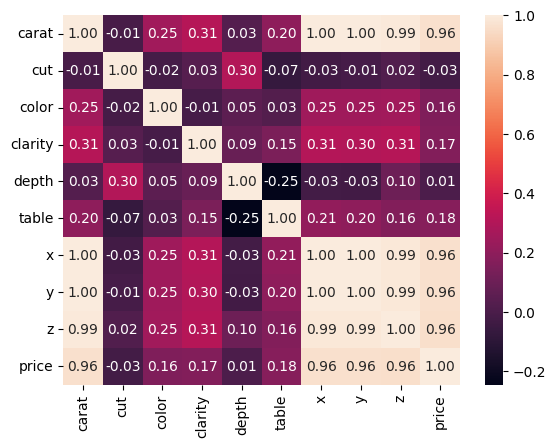

In [17]:
sns.heatmap(db2.corr(method='spearman'), annot=True, fmt=".2f")

In [18]:
db2 = db2.drop(columns = ["x", "y", "z"])

<AxesSubplot: >

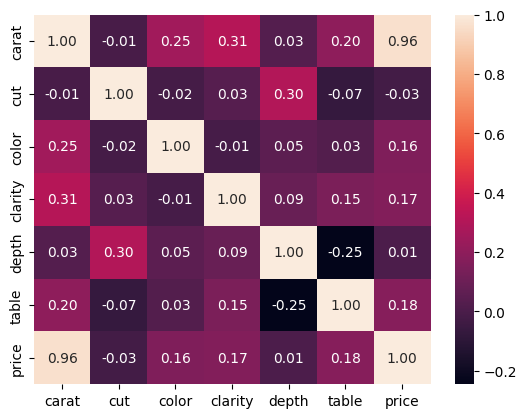

In [20]:
sns.heatmap(db2.corr(method='spearman'), annot=True, fmt='.2f')

<AxesSubplot: xlabel='price', ylabel='Count'>

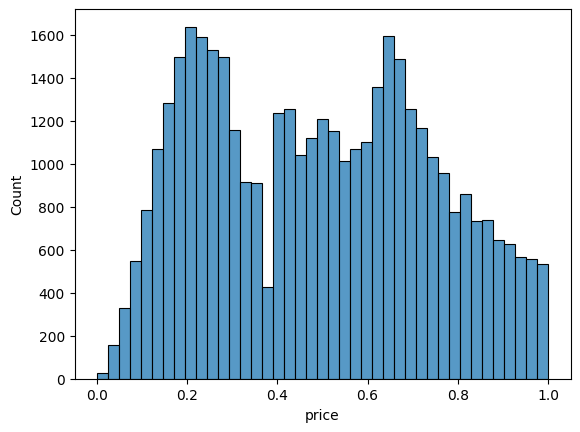

In [21]:
sns.histplot(db2['price'])

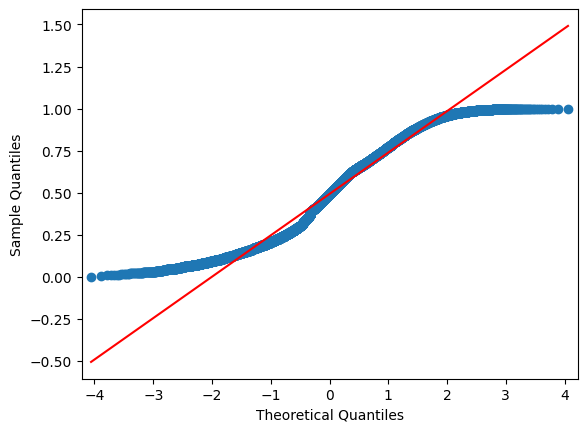

In [22]:
qqplot_price = sm.qqplot(db2["price"], line='r')

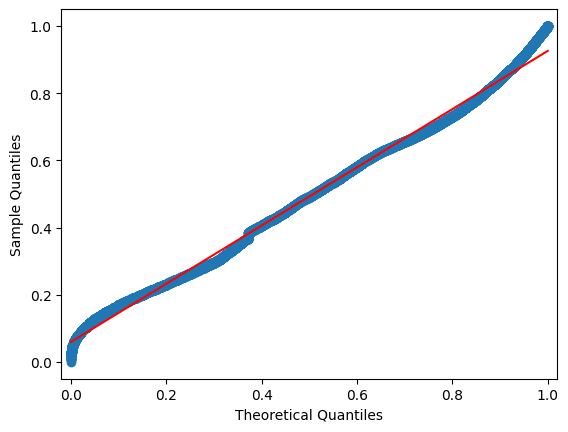

In [23]:
qqplot_price = sm.qqplot(db2['price'], dist=stats.uniform, line='r')

<AxesSubplot: xlabel='price', ylabel='Count'>

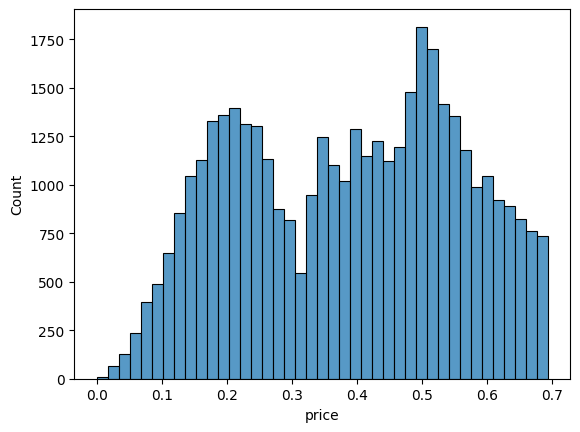

In [24]:
sns.histplot(np.log(db2['price'] + 1))

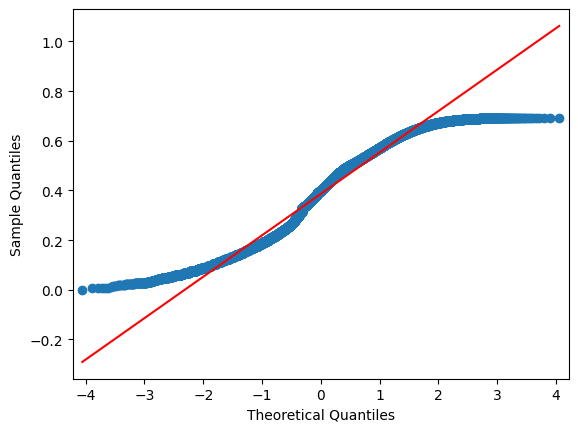

In [25]:
qqplot_price = sm.qqplot(np.log(db2['price'] + 1), line='r')

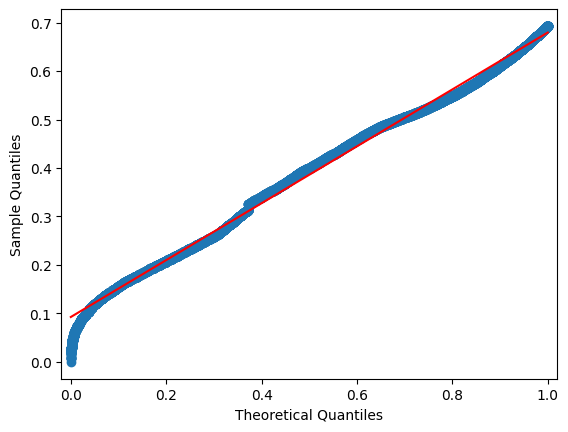

In [26]:
qqplot_price = sm.qqplot(
    np.log(db2['price'] + 1), dist=stats.uniform, line='r')

## 2.2 Removing outliers

In [27]:
db_temp = db2[["carat", "depth", "table", "price"]].values

In [28]:
column_eif = iso.iForest(
    db_temp, ntrees=500, sample_size=256, ExtensionLevel=1)

In [29]:
S1 = column_eif.compute_paths(X_in = db_temp)

In [30]:
int(len(S1) * 0.05)

2022

In [31]:
np.argsort(S1)[-int(len(S1) * 0.05):]

array([33044,  1889, 40424, ..., 16230,  7978, 29785])

In [32]:
mod_data = db2.loc[np.argsort(S1)[:-int(len(S1) * 0.05)]]

In [33]:
db2.std(), mod_data.std()

(carat      0.098948
 cut        0.180446
 color      0.325753
 clarity    0.114044
 depth      0.039911
 table      0.043815
 price      0.250759
 dtype: float64,
 carat      0.084690
 cut        0.159676
 color      0.322265
 clarity    0.103854
 depth      0.035471
 table      0.040754
 price      0.239425
 dtype: float64)

In [40]:
mod_data.groupby("cut")[["cut"]].count(), db2.groupby("cut")[["cut"]].count()

(            cut
 cut            
 0.000000   9830
 0.161548  15897
 0.198164   8607
 0.392855   3340
 1.000000    759,
             cut
 cut            
 0.000000  10338
 0.161548  16230
 0.198164   9003
 0.392855   3682
 1.000000   1202)

In [41]:
mod_data.describe()

,carat,cut,color,clarity,depth,table,price
count,38433.000000,38433.000000,38433.000000,38433.000000,38433.000000,38433.000000,38433.000000
mean,0.114201,0.165089,0.378722,0.187354,0.521292,0.261619,0.477003
std,0.084690,0.159676,0.322265,0.103854,0.035471,0.040754,0.239425
min,0.000000,0.000000,0.000000,0.000000,0.355556,0.098039,0.006658
25%,0.039501,0.000000,0.139749,0.141467,0.502778,0.235294,0.257460
50%,0.103950,0.161548,0.453828,0.166956,0.522222,0.254902,0.478915
75%,0.170478,0.198164,0.752440,0.266833,0.541667,0.294118,0.671270
max,0.409563,1.000000,1.000000,1.000000,0.688889,0.431373,1.000000


## Загрузка данныв в бд

In [42]:
from sqlalchemy import create_engine

In [43]:
conn = create_engine("sqlite:///Diamonds")

In [44]:
mod_data.to_sql(name="Diamond_reworked", con=conn, if_exists="replace")

38433

In [48]:
%%sql

sq

 * sqlite:///Diamonds
Done.


[]